In [1]:
import pandas as pd
import os

# 현재 파이썬 코드의 파일 경로
current_path = os.getcwd()  # 현재 작업 디렉토리를 가져옵니다.

# CSV 파일 경로
file_path = os.path.join(current_path, 'filtered_data.csv')  # User uploaded fioytle to this path

df = pd.read_csv(file_path)
df

,note id,person id,age,gender source value,BMI,admission department,division,ward,asa class,surgeon id,...,condition source value,surgery room,previous surgery,emergency status,op timing,day of the week,week of the month,month,surgeon estimated op time,surgery duration
0,101058,29,81,F,25.247087,General Surgery,Admission,NUGW2,2,9885,...,D00002196,203,N,N,TF2,Thursday,4,October,130,66
1,57801,64,60,F,24.376249,Otolaryngology,Admission,102,2,6194,...,D00003798,504,N,N,8A,Friday,2,January,300,130
2,71288,64,60,F,24.376249,Otolaryngology,Admission,102,3,6194,...,D00003798,504,Y,N,TF4,Monday,4,April,100,85
3,135104,64,60,F,24.376249,Otolaryngology,Admission,102,3,6194,...,D00003798,504,Y,N,TF2,Monday,3,August,100,83
4,221210,71,94,M,27.963140,Orthopedics,Admission,41,2,29473,...,D00018711,108,N,N,TF4,Monday,5,March,100,63
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
161214,297111,4055249,1,M,23.700428,Pediatric Surgery,Admission,5A,1,100613,...,D00011688,5,N,Y,etc,Tuesday,2,September,200,123
161215,297455,4055328,1,M,20.612160,Pediatric Urology,Day,PDSC,1,6259,...,D00016707,7,N,N,8A,Monday,4,September,130,45
161216,297761,4055407,1,M,12.502703,Pediatric Surgery,Admission,5A,2,105057,...,D00011524,5,N,N,8A,Wednesday,3,September,130,43
161217,297753,4055558,4,F,14.365794,Pediatric Surgery,Admission,5A,2,105057,...,D00004831,5,N,N,TF6,Wednesday,3,September,130,82


In [2]:
from sklearn.model_selection import train_test_split

# Removing unnecessary columns
df.drop(columns=['note id', 'person id', 'surgeon estimated op time', 'final op name'], inplace=True)

# Encoding binary columns
binary_cols = ['condition source value', 'op code', 'surgeon id', 'ward', 'admission department', 'surgery room']
for col in binary_cols:
    df[col] = df[col].astype('category').cat.codes

# One-hot encoding for other categorical columns
one_hot_cols = ['surgical department', 'op timing', 'month', 'anesthesia type', 
                'day of the week', 'asa class', 'week of the month', 
                'division', 'previous surgery', 'emergency status', 'gender source value']
df_encoded = pd.get_dummies(df, columns=one_hot_cols)

# Splitting the data
X_all = df_encoded.drop("surgery duration", axis=1)
y_all = df_encoded["surgery duration"]
X_train_all, X_test_all, y_train_all, y_test_all = train_test_split(X_all, y_all, test_size=0.2, random_state=42)

# Displaying the first few rows of the resulting dataframe
X_train_all
y_train_all


61344     122
137241     48
139478     76
113549     36
149411    127
         ... 
119879     76
103694     57
131932    311
146867     82
121958     57
Name: surgery duration, Length: 128975, dtype: int64

In [12]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import numpy as np

# 분과별 데이터셋 준비
departments = df['surgical department'].unique()
models = {}
predictions = {}

# 각 분과별 모델 훈련
for dept in departments:
    # 열 이름 조정
    dept_col_name = 'surgical department_' + dept

    # 분과별 데이터 필터링
    dept_data = df_encoded[df_encoded[dept_col_name] == 1]
    X_dept = dept_data.drop('surgery duration', axis=1)
    y_dept = dept_data['surgery duration']

    # 데이터 분할
    X_train_dept, X_test_dept, y_train_dept, y_test_dept = train_test_split(X_dept, y_dept, test_size=0.2, random_state=42)

    # 모델 훈련
    model = RandomForestRegressor(n_estimators=100, random_state=42)
    model.fit(X_train_dept, y_train_dept)
    models[dept] = model

    # 테스트 데이터셋에 대한 예측 수행
    predictions[dept] = model.predict(X_test_dept)

# 앙상블을 위한 준비
final_predictions = np.zeros(len(X_test_all))
test_indices = X_test_all.index

# 각 분과별 모델을 전체 테스트 데이터셋에 적용
for dept, model in models.items():
    # 열 이름 조정
    dept_col_name = 'surgical department_' + dept

    # 해당 분과에 해당하는 테스트 데이터 인덱스
    dept_indices = X_test_all[X_test_all[dept_col_name] == 1].index

    # 해당 분과의 예측값 계산
    dept_predictions = model.predict(X_test_all.loc[dept_indices])

    # 최종 예측 배열에 해당 부분 업데이트
    final_predictions[np.isin(test_indices, dept_indices)] = dept_predictions

# 성능 평가
mae_lr = mean_absolute_error(y_test_all, final_predictions)
rmse_lr = np.sqrt(mean_squared_error(y_test_all, final_predictions))
r2_lr = r2_score(y_test_all, final_predictions)

print(f"Ensemble MAE: {mae_lr}, RMSE: {rmse_lr}, R²: {r2_lr}")

Ensemble MAE: 16.67870301451433, RMSE: 31.662393537060968, R²: 0.9158268414503081


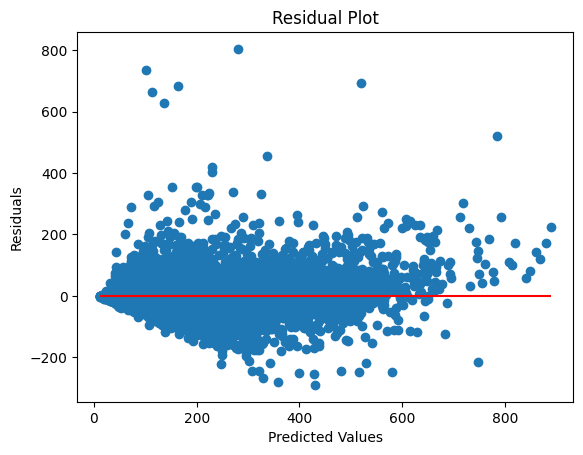

In [17]:
import matplotlib.pyplot as plt

# 잔차 계산
residuals = y_test_all - final_predictions

# Residual Plot 생성
plt.scatter(final_predictions, residuals)
plt.hlines(y=0, xmin=final_predictions.min(), xmax=final_predictions.max(), colors='red')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.show()


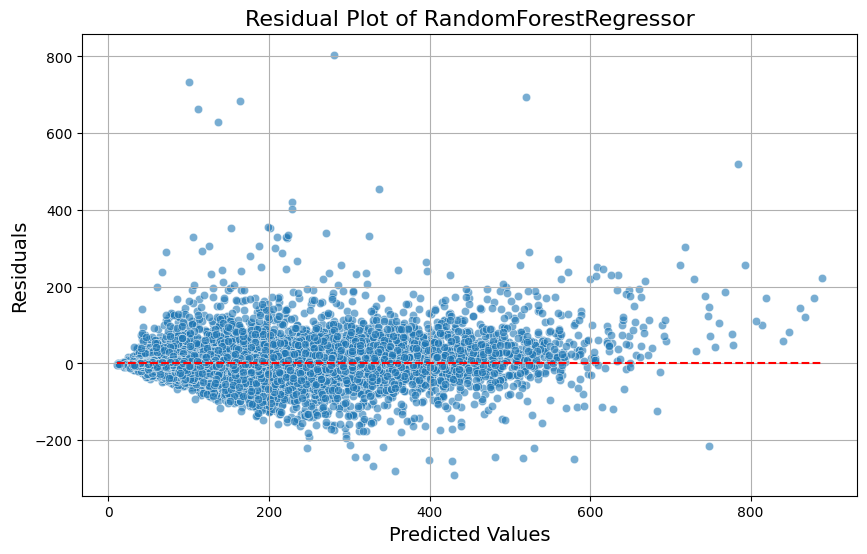

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns

# 잔차 계산
residuals = y_test_all - final_predictions

# Residual Plot 생성
plt.figure(figsize=(10, 6))
sns.scatterplot(x=final_predictions, y=residuals, alpha=0.6)
plt.hlines(y=0, xmin=final_predictions.min(), xmax=final_predictions.max(), colors='red', linestyles='dashed')
plt.xlabel('Predicted Values', fontsize=14)
plt.ylabel('Residuals', fontsize=14)
plt.title('Residual Plot of RandomForestRegressor', fontsize=16)
plt.grid(True)
plt.show()



In [15]:
from sklearn.metrics import mean_absolute_error

# Dictionary to store MAE for each department
department_mae = {}

for dept in departments:
    dept_col_name = 'surgical department_' + dept
    dept_data = df_encoded[df_encoded[dept_col_name] == 1]
    
    # Split the data for the department
    X_dept = dept_data.drop('surgery duration', axis=1)
    y_dept = dept_data['surgery duration']
    _, X_test_dept, _, y_test_dept = train_test_split(X_dept, y_dept, test_size=0.2, random_state=42)

    # Train the model and make predictions for the department
    model = RandomForestRegressor(n_estimators=100, random_state=42)
    model.fit(X_train_dept, y_train_dept)
    predictions_dept = model.predict(X_test_dept)

    # Calculate MAE for this department
    mae = mean_absolute_error(y_test_dept, predictions_dept)
    department_mae[dept] = mae

department_mae


{'General Surgery': 201.79386070743075,
 'Otolaryngology': 206.80292569002123,
 'Orthopedics': 205.85289109506618,
 'Ophthalmology': 297.670564793578,
 'Obstetrics & Gynecology': 213.89348827106866,
 'Urology': 308.16266378972153,
 'Plastic Surgery': 233.19744680851062,
 'Neurosurgery': 150.40032684283727,
 'Cardiovascular Thoracic Surgery': 186.302835741038,
 'Pediatric Otolaryngology': 221.10030355594103,
 'Pediatric Orthopedics': 123.39385403329067,
 'Pediatric Thoracic Surgery': 138.78438829787237,
 'Pediatric Urology': 240.45141176470588,
 'Pediatric Surgery': 174.36525465838508,
 'Pediatric Ophthalmology': 212.53045165394403,
 'Pediatric Plastic Surgery': 153.02922352941178,
 'Pediatric Neurosurgery': 67.89452991452991}

In [27]:
from sklearn.linear_model import LinearRegression

# 분과별 데이터셋 준비
departments = df['surgical department'].unique()
models = {}
predictions = {}

# 각 분과별 모델 훈련
for dept in departments:
    # 열 이름 조정
    dept_col_name = 'surgical department_' + dept

    # 분과별 데이터 필터링
    dept_data = df_encoded[df_encoded[dept_col_name] == 1]
    X_dept = dept_data.drop('surgery duration', axis=1)
    y_dept = dept_data['surgery duration']

    # 데이터 분할
    X_train_dept, X_test_dept, y_train_dept, y_test_dept = train_test_split(X_dept, y_dept, test_size=0.2, random_state=42)

    # 모델 훈련
    model = LinearRegression()
    model.fit(X_train_dept, y_train_dept)
    models[dept] = model

    # 테스트 데이터셋에 대한 예측 수행
    predictions[dept] = model.predict(X_test_dept)

# 앙상블을 위한 준비
final_predictions = np.zeros(len(X_test_all))
test_indices = X_test_all.index

# 각 분과별 모델을 전체 테스트 데이터셋에 적용
for dept, model in models.items():
    # 열 이름 조정
    dept_col_name = 'surgical department_' + dept

    # 해당 분과에 해당하는 테스트 데이터 인덱스
    dept_indices = X_test_all[X_test_all[dept_col_name] == 1].index

    # 해당 분과의 예측값 계산
    dept_predictions = model.predict(X_test_all.loc[dept_indices])

    # 최종 예측 배열에 해당 부분 업데이트
    final_predictions[np.isin(test_indices, dept_indices)] = dept_predictions

# 성능 평가
mae_lr = mean_absolute_error(y_test_all, final_predictions)
rmse_lr = np.sqrt(mean_squared_error(y_test_all, final_predictions))
r2_lr = r2_score(y_test_all, final_predictions)

print(f"Ensemble MAE: {mae_lr}, RMSE: {rmse_lr}, R²: {r2_lr}")

Ensemble MAE: 50.2211215236737, RMSE: 76.9795817900624, R²: 0.5024494234514032


In [28]:
from xgboost import XGBRegressor

# 분과별 데이터셋 준비
departments = df['surgical department'].unique()
models = {}
predictions = {}

# 각 분과별 모델 훈련
for dept in departments:
    # 열 이름 조정
    dept_col_name = 'surgical department_' + dept

    # 분과별 데이터 필터링
    dept_data = df_encoded[df_encoded[dept_col_name] == 1]
    X_dept = dept_data.drop('surgery duration', axis=1)
    y_dept = dept_data['surgery duration']

    # 데이터 분할
    X_train_dept, X_test_dept, y_train_dept, y_test_dept = train_test_split(X_dept, y_dept, test_size=0.2, random_state=42)

    # 모델 훈련
    model = XGBRegressor(random_state=42)
    model.fit(X_train_dept, y_train_dept)
    models[dept] = model

    # 테스트 데이터셋에 대한 예측 수행
    predictions[dept] = model.predict(X_test_dept)

# 앙상블을 위한 준비
final_predictions = np.zeros(len(X_test_all))
test_indices = X_test_all.index

# 각 분과별 모델을 전체 테스트 데이터셋에 적용
for dept, model in models.items():
    # 열 이름 조정
    dept_col_name = 'surgical department_' + dept

    # 해당 분과에 해당하는 테스트 데이터 인덱스
    dept_indices = X_test_all[X_test_all[dept_col_name] == 1].index

    # 해당 분과의 예측값 계산
    dept_predictions = model.predict(X_test_all.loc[dept_indices])

    # 최종 예측 배열에 해당 부분 업데이트
    final_predictions[np.isin(test_indices, dept_indices)] = dept_predictions

# 성능 평가
mae_xgb = mean_absolute_error(y_test_all, final_predictions)
rmse_xgb = np.sqrt(mean_squared_error(y_test_all, final_predictions))
r2_xgb = r2_score(y_test_all, final_predictions)

print(f"Ensemble MAE: {mae_xgb}, RMSE: {rmse_xgb}, R²: {r2_xgb}")

Ensemble MAE: 22.601232791322957, RMSE: 37.310003900594154, R²: 0.883120935189753


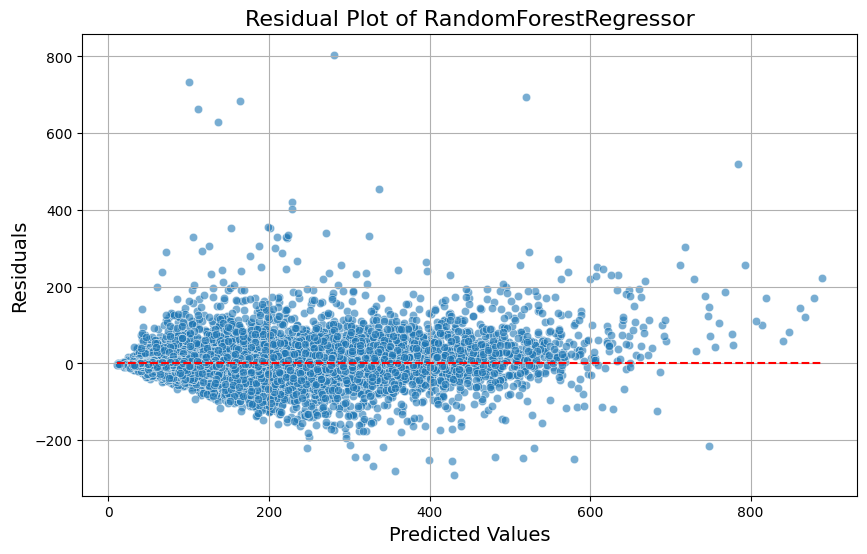

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming y_test_all and final_predictions are defined
# Calculate residuals
residuals = y_test_all - final_predictions

# Create an enhanced Residual Plot
plt.figure(figsize=(10, 6))
sns.scatterplot(x=final_predictions, y=residuals, alpha=0.6)
plt.hlines(y=0, xmin=final_predictions.min(), xmax=final_predictions.max(), color='red', linestyles='dashed')
plt.xlabel('Predicted Values', fontsize=14)
plt.ylabel('Residuals', fontsize=14)
plt.title('Residual Plot of RandomForestRegressor', fontsize=16)
plt.grid(True)
plt.show()


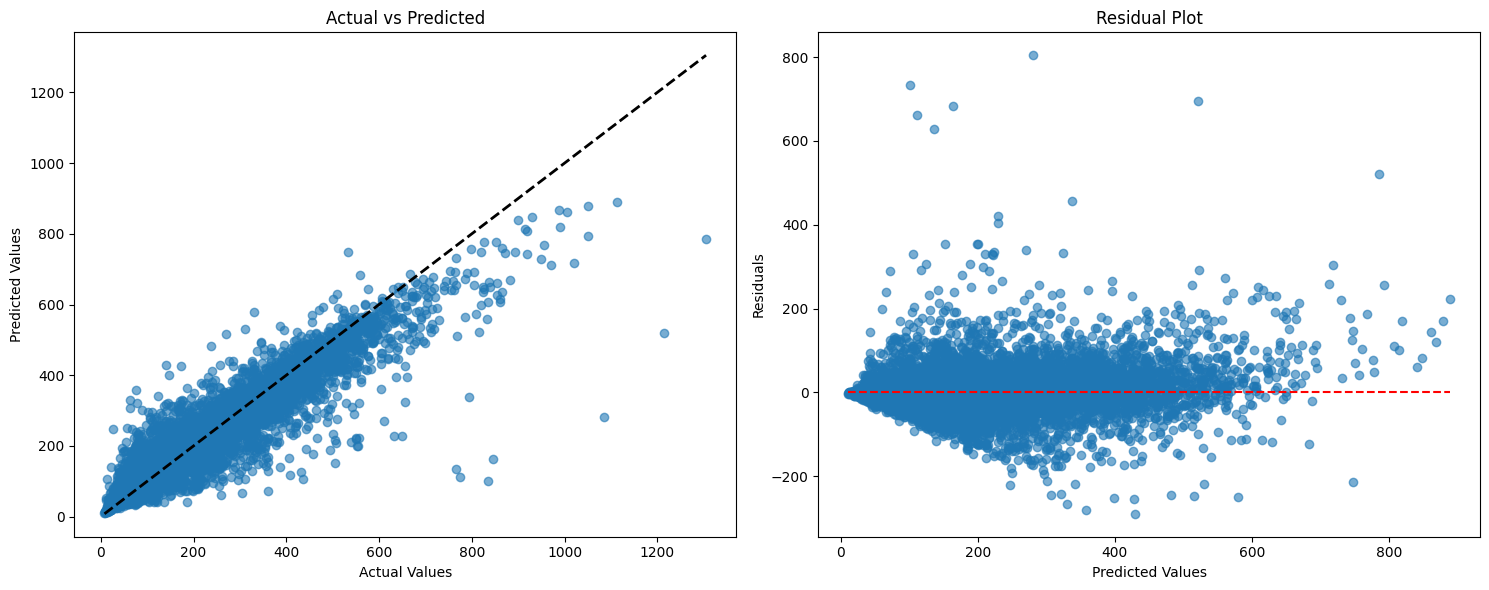

In [20]:
import matplotlib.pyplot as plt

# 실제 값과 예측 값 준비
actual_values = y_test_all
predicted_values = final_predictions

# 잔차 계산
residuals = actual_values - predicted_values

# 그래프 생성
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))

# 실제 값 vs 예측 값
axes[0].scatter(actual_values, predicted_values, alpha=0.6)
axes[0].plot([actual_values.min(), actual_values.max()], [actual_values.min(), actual_values.max()], 'k--', lw=2)
axes[0].set_xlabel('Actual Values')
axes[0].set_ylabel('Predicted Values')
axes[0].set_title('Actual vs Predicted')

# Residual Plot
axes[1].scatter(predicted_values, residuals, alpha=0.6)
axes[1].hlines(y=0, xmin=predicted_values.min(), xmax=predicted_values.max(), colors='red', linestyles='dashed')
axes[1].set_xlabel('Predicted Values')
axes[1].set_ylabel('Residuals')
axes[1].set_title('Residual Plot')

plt.tight_layout()
plt.show()


In [22]:
import matplotlib.pyplot as plt

# RandomForestRegressor 모델의 예측
final_predictions_rf = models['RandomForest'].predict(X_test_all)

# DecisionTreeRegressor 모델의 예측
final_predictions_dt = models['DecisionTree'].predict(X_test_all)

# 각 모델의 예측값에 대한 잔차 계산
residuals_rf = y_test_all - final_predictions_rf
residuals_dt = y_test_all - final_predictions_dt

# Residual Plot 생성
plt.figure(figsize=(10, 6))
plt.scatter(final_predictions_rf, residuals_rf, alpha=0.5, label='Random Forest', color='blue')
plt.scatter(final_predictions_dt, residuals_dt, alpha=0.5, label='Decision Tree', color='green')
plt.hlines(y=0, xmin=min(final_predictions_rf.min(), final_predictions_dt.min()), xmax=max(final_predictions_rf.max(), final_predictions_dt.max()), colors='red', linestyles='dashed')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residual Plot Comparison')
plt.legend()
plt.show()


KeyError: 'RandomForest'

In [4]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import numpy as np

# 분과별 데이터셋 준비
departments = df['surgical department'].unique()
models = {}
predictions = {}

# 각 분과별 모델 훈련
for dept in departments:
    # 열 이름 조정
    dept_col_name = 'surgical department_' + dept

    # 분과별 데이터 필터링
    dept_data = df_encoded[df_encoded[dept_col_name] == 1]
    X_dept = dept_data.drop('surgery duration', axis=1)
    y_dept = dept_data['surgery duration']

    # 데이터 분할
    X_train_dept, X_test_dept, y_train_dept, y_test_dept = train_test_split(X_dept, y_dept, test_size=0.2, random_state=42)

    # 모델 훈련
    model = DecisionTreeRegressor(random_state=42)
    model.fit(X_train_dept, y_train_dept)
    models[dept] = model

    # 테스트 데이터셋에 대한 예측 수행
    predictions[dept] = model.predict(X_test_dept)

# 앙상블을 위한 준비
final_predictions = np.zeros(len(X_test_all))
test_indices = X_test_all.index

# 각 분과별 모델을 전체 테스트 데이터셋에 적용
for dept, model in models.items():
    # 열 이름 조정
    dept_col_name = 'surgical department_' + dept

    # 해당 분과에 해당하는 테스트 데이터 인덱스
    dept_indices = X_test_all[X_test_all[dept_col_name] == 1].index

    # 해당 분과의 예측값 계산
    dept_predictions = model.predict(X_test_all.loc[dept_indices])

    # 최종 예측 배열에 해당 부분 업데이트
    final_predictions[np.isin(test_indices, dept_indices)] = dept_predictions

# 성능 평가
mae_dt = mean_absolute_error(y_test_all, final_predictions)
rmse_dt = np.sqrt(mean_squared_error(y_test_all, final_predictions))
r2_dt = r2_score(y_test_all, final_predictions)

print(f"Ensemble MAE: {mae_dt}, RMSE: {rmse_dt}, R²: {r2_dt}")

Ensemble MAE: 8.789387172807343, RMSE: 33.36653615556264, R²: 0.9065222205584245


In [5]:
# Adjusting the code to calculate and display the MAE for each department

from sklearn.metrics import mean_absolute_error

# Dictionary to store MAE for each department
department_mae = {}

for dept, model in models.items():
    dept_col_name = 'surgical department_' + dept
    dept_indices = X_test_all[X_test_all[dept_col_name] == 1].index

    # Check if the department has test data
    if len(dept_indices) > 0:
        # Calculate predictions for this department
        dept_predictions = model.predict(X_test_all.loc[dept_indices])

        # Extract the actual values for this department from the whole test dataset
        actual_values = y_test_all.loc[dept_indices]

        # Calculate MAE for this department
        mae = mean_absolute_error(actual_values, dept_predictions)
        department_mae[dept] = mae

department_mae



{'General Surgery': 9.49593383873191,
 'Otolaryngology': 10.50947459086994,
 'Orthopedics': 10.144918821407096,
 'Ophthalmology': 3.6727115716753023,
 'Obstetrics & Gynecology': 10.022933794893985,
 'Urology': 6.10071371927042,
 'Plastic Surgery': 11.034029850746268,
 'Neurosurgery': 12.349152542372881,
 'Cardiovascular Thoracic Surgery': 12.488384371700105,
 'Pediatric Otolaryngology': 6.259421560035057,
 'Pediatric Orthopedics': 13.420986093552465,
 'Pediatric Thoracic Surgery': 13.419270833333334,
 'Pediatric Urology': 8.743455497382199,
 'Pediatric Surgery': 5.699167657550535,
 'Pediatric Ophthalmology': 3.1666666666666665,
 'Pediatric Plastic Surgery': 8.358916478555305,
 'Pediatric Neurosurgery': 14.060085836909872}

In [1]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# 분과별 데이터셋 준비
departments = df['surgical department'].unique()
models = {}
predictions = {}

# 각 분과별 모델 훈련
for dept in departments:
    dept_col_name = 'surgical department_' + dept
    dept_data = df_encoded[df_encoded[dept_col_name] == 1]
    X_dept = dept_data.drop('surgery duration', axis=1)
    y_dept = dept_data['surgery duration']

    # 데이터 분할 및 정규화
    X_train_dept, X_test_dept, y_train_dept, y_test_dept = train_test_split(X_dept, y_dept, test_size=0.2, random_state=42)
    scaler = StandardScaler()
    X_train_dept = scaler.fit_transform(X_train_dept)
    X_test_dept = scaler.transform(X_test_dept)

    # 신경망 모델 구성
    model = Sequential([
        Dense(128, activation='relu', input_shape=(X_train_dept.shape[1],)),
        Dense(64, activation='relu'),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mean_squared_error')

    # 모델 학습
    model.fit(X_train_dept, y_train_dept, epochs=10, batch_size=32, verbose=0)
    models[dept] = model

    # 테스트 데이터셋에 대한 예측 수행
    predictions[dept] = model.predict(X_test_dept).flatten()

# 앙상블을 위한 준비
final_predictions = np.zeros(len(X_test_all))
test_indices = X_test_all.index

# 각 분과별 모델을 전체 테스트 데이터셋에 적용
for dept, model in models.items():
    dept_col_name = 'surgical department_' + dept
    dept_indices = X_test_all[X_test_all[dept_col_name] == 1].index
    X_test_all_scaled = scaler.transform(X_test_all.loc[dept_indices])
    dept_predictions = model.predict(X_test_all_scaled).flatten()
    final_predictions[np.isin(test_indices, dept_indices)] = dept_predictions

# 성능 평가
mae_dl = mean_absolute_error(y_test_all, final_predictions)
rmse_dl = np.sqrt(mean_squared_error(y_test_all, final_predictions))
r2_dl = r2_score(y_test_all, final_predictions)

print(f"Deep Learning Ensemble MAE: {mae_dl}, RMSE: {rmse_dl}, R²: {r2_dl}")


ModuleNotFoundError: No module named 'tensorflow'

In [31]:
from lightgbm import LGBMRegressor

# 분과별 데이터셋 준비
departments = df['surgical department'].unique()
models = {}
predictions = {}

# 각 분과별 모델 훈련
for dept in departments:
    # 열 이름 조정
    dept_col_name = 'surgical department_' + dept

    # 분과별 데이터 필터링
    dept_data = df_encoded[df_encoded[dept_col_name] == 1]
    X_dept = dept_data.drop('surgery duration', axis=1)
    y_dept = dept_data['surgery duration']

    # 데이터 분할
    X_train_dept, X_test_dept, y_train_dept, y_test_dept = train_test_split(X_dept, y_dept, test_size=0.2, random_state=42)

    # 모델 훈련
    model = LGBMRegressor(random_state=42)
    model.fit(X_train_dept, y_train_dept)
    models[dept] = model

    # 테스트 데이터셋에 대한 예측 수행
    predictions[dept] = model.predict(X_test_dept)

# 앙상블을 위한 준비
final_predictions = np.zeros(len(X_test_all))
test_indices = X_test_all.index

# 각 분과별 모델을 전체 테스트 데이터셋에 적용
for dept, model in models.items():
    # 열 이름 조정
    dept_col_name = 'surgical department_' + dept

    # 해당 분과에 해당하는 테스트 데이터 인덱스
    dept_indices = X_test_all[X_test_all[dept_col_name] == 1].index

    # 해당 분과의 예측값 계산
    dept_predictions = model.predict(X_test_all.loc[dept_indices])

    # 최종 예측 배열에 해당 부분 업데이트
    final_predictions[np.isin(test_indices, dept_indices)] = dept_predictions

# 성능 평가
mae_lgbm = mean_absolute_error(y_test_all, final_predictions)
rmse_lgbm = np.sqrt(mean_squared_error(y_test_all, final_predictions))
r2_lgbm = r2_score(y_test_all, final_predictions)

print(f"Ensemble MAE: {mae_lgbm}, RMSE: {rmse_lgbm}, R²: {r2_lgbm}")

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004387 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1089
[LightGBM] [Info] Number of data points in the train set: 29172, number of used features: 66
[LightGBM] [Info] Start training from score 156.203071
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001133 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 935
[LightGBM] [Info] Number of data points in the train set: 9417, number of used features: 58
[LightGBM] [Info] Start training from score 138.766380
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM]

In [40]:
def evaluate_model(model, X_train, y_train, X_test, y_test):
    # Train the model
    model.fit(X_train, y_train)

    # Make predictions on the test set
    predictions = model.predict(X_test)

    # Calculate performance metrics
    mae = mean_absolute_error(y_test, predictions)
    mse = mean_squared_error(y_test, predictions)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, predictions)

    return mae, rmse, r2

# Adding 'surgical_department' back to df_encoded
df_encoded['surgical department'] = df['surgical department']

# Splitting the data based on 'surgical_department'
department_subsets = df_encoded.groupby('surgical department')

model_averages = {
    "Random Forest": [],
    "XGBoost": [],
    "Linear Regression": [],
    "LightGBM": [],
    "Decision Tree": []
}


for department, data in department_subsets:
    X = data.drop(["surgery duration", "surgical department"], axis=1)
    y = data["surgery duration"]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    models = {
        "Random Forest": RandomForestRegressor(random_state=42),
        "XGBoost": XGBRegressor(random_state=42),
        "Linear Regression": LinearRegression(),
        "LightGBM": LGBMRegressor(random_state=42),
        "Decision Tree": DecisionTreeRegressor(random_state=42)
    }

    for name, model in models.items():
        mae, _, _ = evaluate_model(model, X_train, y_train, X_test, y_test)
        model_averages[name].append(mae)

# Calculate the average MAE for each model across all departments
average_mae_per_model = {model: np.mean(maes) for model, maes in model_averages.items()}
average_mae_per_model

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000525 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 846
[LightGBM] [Info] Number of data points in the train set: 7472, number of used features: 54
[LightGBM] [Info] Start training from score 233.097698
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001111 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1089
[LightGBM] [Info] Number of data points in the train set: 29172, number of used features: 66
[LightGBM] [Info] Start training from score 156.203071
[LightGBM] [Warning] Found

{'Random Forest': 37.62154149027628,
 'XGBoost': 38.86618902617419,
 'Linear Regression': 54.28266078623502,
 'LightGBM': 37.66210130359778,
 'Decision Tree': 49.840933944191285}